# Data Clustering

steps in this notebook

1. pull in the data

2. try a simple k means clustering

3. try an autoencoder with k means clustering

4. try and auto encoder with t-sne

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
img_md_subset = pd.read_csv('../../../Data/ifcb_ecotaxa_subset_merged.csv')
img_md_subset = img_md_subset.drop('Unnamed: 0', 1)

pull out a random subset for speed

In [4]:
import glob, os

file_dir = '../../../Data/all_imagery/'

os.chdir(file_dir)
fn_list = []
for file in glob.glob("*.png"):
    fn_list.append(file)


In [5]:
fn_edit = [x[:-4] for x in fn_list]

In [6]:
img_subset_with_data = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(img_subset_with_data)

1328483

In [7]:
class_id_list = [[x, i] for i, x in enumerate(list(img_subset_with_data.groupby('merged_category')['object_id'].nunique().index))]
class_id_dict = {key: value for (key, value) in class_id_list}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())

id_class_dict

{0: 'amphiprora',
 1: 'ceratium',
 2: 'chaetoceros',
 3: 'chaetoceros_mediophyceae',
 4: 'chlorophytes',
 5: 'ciliophora',
 6: 'corethron',
 7: 'cryptophytes',
 8: 'cylindrotheca',
 9: 'dactyliosolen',
 10: 'dinoflagellate_i',
 11: 'dinoflagellate_ii',
 12: 'dinoflagellate_iii',
 13: 'dinophyceae',
 14: 'eucampia',
 15: 'eucampia_chain',
 16: 'general_centric_diatoms',
 17: 'general_dinoflagellates',
 18: 'general_pennate_diatoms',
 19: 'guinardia',
 20: 'gymnodinium',
 21: 'haptophytes',
 22: 'katodinium',
 23: 'nitzschia_frigida',
 24: 'other',
 25: 'proboscia',
 26: 'pseudo_nitzschia_chain',
 27: 'silicoflagellates',
 28: 'small_unidentified_cells',
 29: 'tintinnida',
 30: 'torodinium',
 31: 'unidenfitied_chain_pennates',
 32: 'unidentified_chain_centrics',
 33: 'unidentified_diatoms',
 34: 'unidentified_flagellates',
 35: 'unidentified_living_cells',
 36: 'unidentified_single_centrics',
 37: 'unidentified_single_pennates'}

In [8]:
df_val = img_subset_with_data[img_subset_with_data.object_annotation_status == 'validated']
df_val.head()

object_id object_annotation_status  \
3134  D20171114T184512_IFCB116_00017                validated   
3196  D20171114T191311_IFCB116_02541                validated   
3197  D20171114T191311_IFCB116_01183                validated   
3198  D20171114T191311_IFCB116_00659                validated   
3199  D20171114T191311_IFCB116_01034                validated   

     object_annotation_category  \
3134                Pyramimonas   
3196                Pyramimonas   
3197                Pyramimonas   
3198               Dictyochales   
3199                  Corethron   

                            object_annotation_hierarchy sample_flag  \
3134  living>Eukaryota>Archaeplastida>Viridiplantae>...  incomplete   
3196  living>Eukaryota>Archaeplastida>Viridiplantae>...  incomplete   
3197  living>Eukaryota>Archaeplastida>Viridiplantae>...  incomplete   
3198  living>Eukaryota>Harosa>Stramenopiles>Ochrophy...  incomplete   
3199  living>Eukaryota>Harosa>Stramenopiles>Ochrophy...  incomplete   

      object_lat  object_lon  object_date  object_time    merged_category  \
3134    -64.7795    -64.0417     20171114       184512       chlorophytes   
3196    -64.7795    -64.0417     20171114       191311       chlorophytes   
3197    -64.7795    -64.0417     20171114       191311       chlorophytes   
3198    -64.7795    -64.0417     20171114       191311  silicoflagellates   
3199    -64.7795    -64.0417     20171114       191311          corethron   

                                 geometry  
3134  POINT (-64.04170000000001 -64.7795)  
3196  POINT (-64.04170000000001 -64.7795)  
3197  POINT (-64.04170000000001 -64.7795)  
3198  POINT (-64.04170000000001 -64.7795)  
3199  POINT (-64.04170000000001 -64.7795)

In [67]:
df_sample = img_subset_with_data.sample(20000)
len(df_sample)

20000

These are major outliers so worth taking them out sometimes

In [68]:
df_sample = df_sample[df_sample.merged_category != 'other']
df_sample = df_sample[df_sample.merged_category != 'small_unidentified_cells']
len(df_sample)

10076

Create class name dicts

Pull in all the data to memory

In [69]:
from tensorflow.keras.preprocessing import image
import numpy as np

images = []
labels = []

for index, row in df_sample.iterrows():
    
    # TODO need to think about optimal size and that size actually corresponds to class
    # maybe add blackspace instead of interpolating because it is changing the morphology

    img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    images.append(image.img_to_array(img))
    try:
        labels.append(class_id_dict[row['merged_category']])
    except KeyError: # this is to catch a couple nans
        print('found nan')
        labels.append(class_id_dict['other'])
images = np.array(images)
labels = np.array(labels)

images.shape, labels.shape

((10076, 150, 150, 1), (10076,))

train it on this subset

K-Means

In [70]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

First flatten the data for scikit learn

In [71]:
x_minst = x_train.reshape((x_train.shape[0], -1))

x = images.reshape((images.shape[0], -1))
x.shape, x_minst.shape

((10076, 22500), (60000, 784))

visualize in PCA

In [72]:
X_reduced_minst = PCA(n_components=3).fit_transform(x_minst)
X_reduced_minst.shape

(60000, 3)

In [73]:
X_reduced = PCA(n_components=3).fit_transform(x)
X_reduced.shape

(10076, 3)

In [74]:
df_minst = pd.DataFrame(np.array([X_reduced_minst[:, 0], X_reduced_minst[:, 1], X_reduced_minst[:, 2], 
                                  y_train]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df_minst.head()

pc1         pc2         pc3  label
0   123.928508 -312.661980  -24.684880    5.0
1  1011.717588 -294.850165  596.297977    0.0
2   -51.848692  392.173729 -188.469275    4.0
3  -799.129655 -607.192117  273.533832    1.0
4  -382.753347  730.538074   16.407543    9.0

In [75]:
df = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], [id_class_dict[x] for x in labels]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df.head()

pc1         pc2         pc3                         label
0  -2356.7397  -1415.9622   536.67944     unidentified_living_cells
1  -2976.7832  -627.02563   -969.3813      unidentified_flagellates
2   1200.3113  -1808.0815    695.5808      unidentified_flagellates
3  -3315.2769  -749.23224    1354.494  unidentified_single_pennates
4     975.122    508.0749  -661.34656                  cryptophytes

In [76]:
import plotly.express as px
fig = px.scatter_3d(df_minst.sample(1000), x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

In [77]:
import plotly.express as px
fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

In [78]:
validated_samples = X_reduced[df_sample.object_annotation_status == 'validated']
val_labels = labels[df_sample.object_annotation_status == 'validated']
len(validated_samples)

340

In [79]:
df = pd.DataFrame(np.array([validated_samples[:, 0], validated_samples[:, 1], validated_samples[:, 2], [id_class_dict[x] for x in val_labels]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])

import plotly.express as px
fig = px.scatter_3d(df, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

### convolutional autoencoder

#### MINST for comparison

In [39]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [22]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_train.shape, x_test.shape

((60000, 28, 28, 1), (10000, 28, 28, 1))

In [41]:
y_train.shape, y_test.shape

((60000,), (10000,))

In [ ]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
encoder = Model(input=input_img, output=encoded)
# model.compile(optimizer='sgd', loss='mse') # latest Keras don't need it
encoded_imgs = encoder.predict([x_test])
encoded_imgs.shape

In [ ]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(encoded_imgs[i].reshape(4, 4 * 8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

#### On IFCB Data

Going much smaller than this smallest encoding (currently 19x19x8) didn't lead to a meaningful representation. 5x5x8 didn't do anything and 10x10x8 was also really fuzzy. Removing the scale bar may help this...

In [80]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(150, 150, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [81]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 150, 150, 16)      160       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 8)         1160      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 38, 38, 8)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 38, 38, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 19, 19, 8)         0         
__________

In [82]:
# autoencoder.fit(x_train, x_train,
#                 epochs=50,
#                 batch_size=128,
#                 shuffle=True,
#                 validation_data=(x_test, x_test))

In [83]:
images.mean(), images.std()

(127.19513, 37.144943)

In [84]:
#imags_norm = (images / 255.0 - 0.475) / 0.12
imags_norm = images / images.max()
# imags_norm = (images - images.mean()) / images.std()

In [85]:
imags_norm.mean(), imags_norm.std(), imags_norm.max(), imags_norm.min()

(0.49880478, 0.1456669, 1.0, 0.0)

In [86]:
from sklearn.model_selection import train_test_split

num_classes = len(class_id_dict)

x_train, x_test, y_train, y_test = train_test_split(imags_norm, labels, test_size=0.20, random_state=42)

In [87]:
history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 8060 samples, validate on 2016 samples
Epoch 1/50
8060/8060 [==============================] - 5s 599us/step - loss: 0.6911 - val_loss: 0.6932
Epoch 2/50
8060/8060 [==============================] - 4s 484us/step - loss: 0.6775 - val_loss: 0.6687
Epoch 3/50
8060/8060 [==============================] - 4s 489us/step - loss: 0.6648 - val_loss: 0.6657
Epoch 4/50
8060/8060 [==============================] - 4s 494us/step - loss: 0.6573 - val_loss: 0.6579
Epoch 5/50
8060/8060 [==============================] - 4s 486us/step - loss: 0.6553 - val_loss: 0.6546
Epoch 6/50
8060/8060 [==============================] - 4s 484us/step - loss: 0.6545 - val_loss: 0.6523
Epoch 7/50
8060/8060 [==============================] - 4s 486us/step - loss: 0.6536 - val_loss: 0.6528
Epoch 8/50
8060/8060 [==============================] - 4s 489us/step - loss: 0.6530 - val_loss: 0.6522
Epoch 9/50
8060/8060 [==============================] - 4s 488us/step - loss: 0.6524 - val_loss: 0.6514
Epoch 10/50
8060

dict_keys(['val_loss', 'loss'])


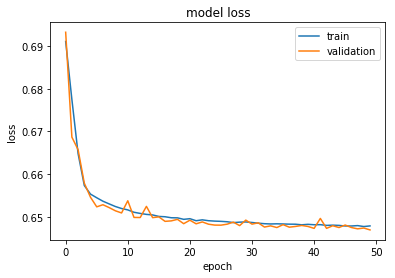

In [88]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

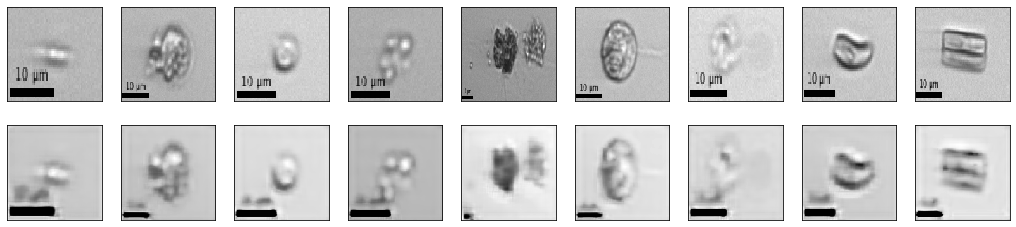

In [89]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(150, 150))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [90]:
encoder = Model(input=input_img, output=encoded)
# model.compile(optimizer='sgd', loss='mse') # latest Keras don't need it
encoded_imgs = encoder.predict([x_test])
encoded_imgs.shape

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: UserWarning:

Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ma..., inputs=Tensor("in...)`



(2016, 19, 19, 8)

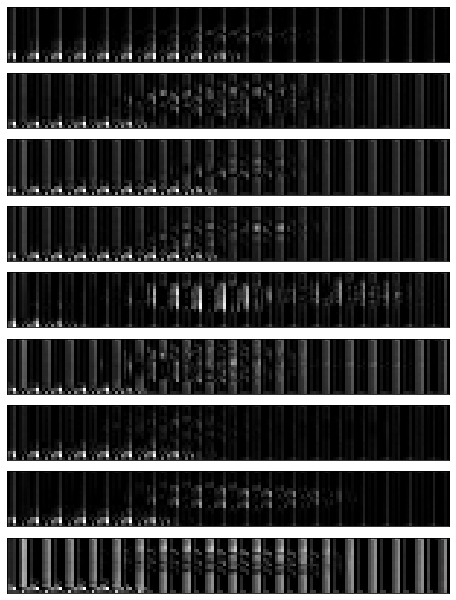

In [91]:
n = 10
plt.figure(figsize=(20, 12))
for i in range(1,n):
    ax = plt.subplot(n, 1, i)
    plt.imshow(encoded_imgs[i].reshape(19, 19 * 8))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

run it on the labeled data to see where it puts stuff

In [92]:
x = encoded_imgs.reshape((encoded_imgs.shape[0], -1))
x.shape

(2016, 2888)

visualize in PCA

In [93]:
X_reduced = PCA(n_components=3).fit_transform(x)
X_reduced.shape

(2016, 3)

In [94]:
y_test

array([35, 37, 20, ..., 34, 34,  4])

In [95]:
df_conv_auto_reduced = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], [id_class_dict[x] for x in  y_test]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df_conv_auto_reduced.head()

pc1         pc2          pc3                         label
0    -9.069574  -1.1455144  -0.95356995     unidentified_living_cells
1  -10.1388855  -3.3674052    1.8984193  unidentified_single_pennates
2    -2.573416   5.9899173    1.1845686                   gymnodinium
3    4.4968762  0.79872346   -2.6467605                  chlorophytes
4    2.2784348  0.73828524   -2.1664436     unidentified_living_cells

In [96]:
import plotly.express as px
fig = px.scatter_3d(df_conv_auto_reduced, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

Run this now on the validated data to see how they fall

In [103]:
from tensorflow.keras.preprocessing import image
import numpy as np

images_val = []
labels_val = []

df_val = df_val[df_val.merged_category != 'other']
df_val = df_val[df_val.merged_category != 'small_unidentified_cells']

for index, row in df_val.iterrows():
    
    # TODO need to think about optimal size and that size actually corresponds to class
    # maybe add blackspace instead of interpolating because it is changing the morphology

    img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
    images_val.append(image.img_to_array(img))
    try:
        labels_val.append(class_id_dict[row['merged_category']])
    except KeyError: # this is to catch a couple nans
        print('found nan')
        labels_val.append(class_id_dict['part<other'])
images_val = np.array(images_val)
labels_val = np.array(labels_val)

images_val.shape, labels_val.shape

((21748, 150, 150, 1), (21748,))

In [104]:
images_norm_val = images_val / images_val.max()

In [105]:
images_norm_val.mean(), images_norm_val.std()

(0.47894955, 0.11739595)

In [106]:
encoded_imgs = encoder.predict([images_norm_val])

In [107]:
x = encoded_imgs.reshape((encoded_imgs.shape[0], -1))

X_reduced = PCA(n_components=3).fit_transform(x)

df_conv_auto_reduced_val = pd.DataFrame(np.array([X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], [id_class_dict[x] for x in labels_val]]).T, 
                  columns=['pc1', 'pc2', 'pc3', 'label'])
df_conv_auto_reduced_val.head()

pc1         pc2         pc3              label
0  -2.8749697   2.7803912   0.4273955       chlorophytes
1  -3.8577235  -6.3085604  0.62509686       chlorophytes
2    4.310488  -4.2306476    1.104066       chlorophytes
3  -7.7010117   2.9028773   3.2086306  silicoflagellates
4  -3.5658252   1.9688424   -4.195823          corethron

In [108]:
fig = px.scatter_3d(df_conv_auto_reduced_val, x='pc1', y='pc2', z='pc3',
              color='label')
fig.show()

Exploring the data:
* think about what classes comprise the output clusters
* what are the largest clusters?
  * how mixed are they?

In [ ]:
Look at each cluster and find the "diversity" in it

In [ ]:
Which clusters are the biggest and what is in them?

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=20, random_state=42).fit(X)

kmeans.labels_

kmeans.predict("a bunch of other images...")

kmeans.cluster_centers_

In [ ]:
create a df with image label, validated or not, and cluster

In [ ]:
look at the clusters ranked by size and by their composition
    do this with and without val

In [ ]:
also try t-sne, and a couple other approaches...